# General Explanation
   ## bibliography
   For writing the ANN algorithm we used the next two sites:
   1. https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23
   2. https://lkaihua.github.io/posts/find-similar-images-based-on-locality-sensitive-hashing/
  
  ## first kneighbors function explanation
  The kneighbors function in the ANN algorithm and the KNN algorithm get one sample at a time and return its kneighbors, but over all the function executed as the numbers of sample there is in the second dataset. i.e. we run over the second dataset with a loop in the necessary places. we decided do to so because it allowing us to keep an orderly recored and easier and clearer way to work with the results on the function.

  ## second kneighbors function explanation
  We use random values for generating the keys for the hash-tables and it able us get different keys randomly. The different keys allow the program to disperse the samples from the first dataset differently each time. For that reason in some cases there are no neighbors to a sample from dataset2, i.e. the sample get key value that doesn't exist in the hash-tables of dataset1. In a similar way it happens when a sample from dataset2 have only one neighbor.

# KNN class
in this class we use the method euclidean from the packege scipy.spatial.distance
this is our implemetation of the KNN algorithm.
the algorithm get the "training" data and saves it in it's variable called "dataset1".
the algorithm search for K  nearest neighbors of one sample that it gets in the knn_kneighbors function. the neighbors calculated by an euclidian distance from the sample to each dot in the dataset1.

In [1]:
from scipy.spatial.distance import euclidean


class Knn(object):

    def __init__(self):
        self.dataset1 = None

    # implementation of reading the data from the csv file
    def fit(self, dataset):
        """
        this method get a dataset and saves it as its dataset
        :param dataset: the 'training' data
        :return: this method is void
        """

        self.dataset1 = dataset


    def knn_kneighbors(self, sample, k):
        """
        this method calculate for a sample dot's vector the distance for each dot's vector in dataset1, saves the
        results in a list and sort it ascending
        :param sample: a 128 vector of the sample dot from the second data csv
        :param k: the number of neighbors to return
        :return: the nearest k neighbors
        """

        distances = []
        counter = 0

        for i in self.dataset1:
            vector = i[4:]
            res = euclidean(sample, vector)
            distances.append([counter, res])
            counter += 1

        distances.sort(key=lambda line: line[1])
        return distances[:k]


# Vector class
this class helps us treat a point from the dataset by splitting it to metadata and the 128 dimensions vector.
this class helps us in the implementation of ANN algorithm (which doen't need the metadata of the point) and its casing (which need the metadata).

In [2]:
class Vector:

    def __init__(self, raw_vector):
        self.metadata = raw_vector[:4]
        self.vector = raw_vector[4:]


# hashTable class
in this class we use the library numpy.


In [3]:
import numpy as np


class HashTable:
    """
    Represents a Hash table for LSH data structure

    The hash function os based on Random Projection Method
    """

    def __init__(self, k, d):
        """
        Initializes the data structure.
        Initializes a matrix with `k` lines and `d` columns with random values.
        This matrix is the `h` vector that will determine the hash key.

        :param k: The size of hash value, aka the key size of the vector in the hash table
        :param d: The amount of dimensions of the input vectors for the data structure
        """

        self.k = k
        self.d = d
        self.hash_table = dict()
        self.h_matrix = np.random.randn(self.k, d)

    def generate_hash(self, vector):
        """
        Generates a hash value (aka key or hash code) for the input vector

        :param vector: An input vector to generate a key for
        :type vector: Vector

        :return: A key that its length is `k` and contains boolean digits
        :rtype: str
        """

        boolean_results = (np.dot(vector.vector, self.h_matrix.T) > 0).astype('int')
        key = ''.join(boolean_results.astype('str'))

        return key

    def __setitem__(self, vector, value):
        """
        Sets the vector in the hash table

        If the key of the vector does not exist in the hash table the method will insert the key
        into the hash table and assign an empty list. Afterward it will append the vector to the key's list

        IF the key exist the method will append the vector to the key's list.

        :param vector: An input vector to set into the hash table
        :type vector: Vector

        :param value: The value to assign
        :type value: Vector
        """
        key = self.generate_hash(vector)

        self.hash_table[key] = self.hash_table.get(key, list()) + [value]

    def __getitem__(self, vector):
        """
        :param vector: An input vector
        :type vector: Vector

        :return: Returns the list of the key that the input vector belongs to.
        :rtype: list
        """

        key = self.generate_hash(vector)

        return self.hash_table.get(key, [])


# LSH class

In [4]:
class LSH:
    """
    Represents a LSH data structure
    """

    def __init__(self, l, k, d):
        """
        :param l: The number of layers of hash tables
        :param k: The length of the hash key
        :param d: The amount of dimensions
        """

        self.l = l
        self.k = k
        self.d = d
        self.hash_tables = list()
        for i in range(self.l):
            self.hash_tables.append(HashTable(self.k, self.d))

    def append(self, vector):
        """
        Insert the vector into the data structure

        :param vector: The vector to insert
        :type vector: Vector
        """

        for hash_table in self.hash_tables:
            hash_table[vector] = vector

    def query(self, vector):
        """
        :param vector:
        :type vector: Vector

        :return: Returns the union of all the lists that the vector appears in the different layers.
                 The values in the returned list is unique
        :rtype: list
        """

        union = list()
        for hash_table in self.hash_tables:
            union.extend(hash_table[vector])

        return list(set(union))


# ANN class
in this class we use the method euclidean from the packege scipy.spatial.distance

In [5]:
from scipy.spatial.distance import euclidean


class Ann:

    def __init__(self):
        self.dataset1 = None
        self.lsh = None

    def fit(self, dataset, l, k):
        """
        this method is an initializing the LSH structure with the dataset

        :param dataset: the 'training' data # I DID CHANGES
        :param l:
        :param k:

        :return: this method is void
        """

        self.dataset1 = dataset
        self.lsh = LSH(l, k, 128)

        for x in range(len(self.dataset1)):
            self.lsh.append(Vector(self.dataset1[x]))

    def ann_kneighbors(self, sample, k):
        """
        this method calculate for a sample dot's vector the distance for each dot's vector in dataset1, saves the
        results in a list and sort it ascending
        :param sample: a 128 vector of the sample dot from the second data csv
        :param k: the number of neighbors to return
        :return: the nearest k neighbors
        """

        distances = []

        neighbors = self.lsh.query(sample)

        for vector in neighbors:
            res = euclidean(sample.vector, vector.vector)
            distances.append([vector.metadata, res])

        distances.sort(key=lambda line: line[1])

        # if the distances is empty it means that the algorithm did no found neighbors for the sample, or if the
        # distances have only 1 result it means that the algorithm did no found enough neighbors for the sample,
        # so we decided to consider both scenarios as no neighbors at all
        if len(distances) == 1:
            return distances[0], None
        elif len(distances) == 0:
            return None, None

        return distances[:k]
    
    def neighbors_by_radios (self, radios, sample):
        """
        this method return all the neighbors of the sample that are in the radios

        :param radios: 1.5*d(NN) we get already calculated whene the method is called
        :param sample: a 128 vector of the sample dot from the second data csv
        :return: list of all the sample's neighbors that in the requested range
        """

        distances = []

        neighbors = self.lsh.query(sample)

        for vector in neighbors:
            res = euclidean(sample.vector, vector.vector)
            if res <= radios:
                distances.append(vector.metadata)

        return distances


# General

In [6]:
import csv
import timeit

class General:

    def __init__(self):
        pass

    def read_dataset(self, file_name):
        """
        this method is an implementation of reading the data from the csv file and saving it in a list
        :param file_name: the file name of the 'training' data
        :return: a list with data from the file
        """

        with open(file_name, 'r') as csvFile:
            csv_reader = csv.reader(csvFile)
            dataset = list(csv_reader)

            # Remove first line (title line)
            dataset = dataset[1:]

            for x in range(len(dataset)):
                for y in range(132):
                    dataset[x][y] = float(dataset[x][y])

        return dataset

    def ratio(self, nearest_n, second_nearest, sample):
        """
        this method calculate the ration between nearest neighbor and second nearest neighbor of a sample that
        given from the kneighbors method.
        :param nearest_n: the first neighbor of the sample
        :param second_nearest: the second neighbor of the sample
        :param sample: the sample dot from the dataset2
        :return: if the ratio is less then 0.8 the first neighbor (the nearest neighbor) is return with the sample
        else None is return for both
        """

        ratio = nearest_n[1]/second_nearest[1]
        if ratio < 0.8:
            return sample[:4], nearest_n[0]
        return None, None

    def ann_epsilon_calculation(self, dataset2, knn, ann, gen):
        """
        In this method we calculate the epsilon (error) of the ANN's kneighbors results.
        For the calculation we used the formula: sigma of all the ANN's kneighbors results of all the samples from dataset2
        devided by the KNN's kneighbors results for each sample respectively, this devided by the number of samples minus
        one.
        We observed that in some cases (usually when the k was too big or the l too small) a point can have no neighbors
        according to the algorithm. Since we wanted to consider these samples as error, we didn't count them in the
        average from the formula, but added the ratio (number of samples without neighbors / number of samples) to the
        error.

        :param dataset2: the 'testing' data
        :param knn: knn's algorithm object
        :param ann: ann's algorithm object
        :param gen: general's object
        :return: epsilon (the error)
        """
        
        distances_ratio = []
        without_neighbors = 0  # counts the samples that got back without neighbors
        bad_ratio = 0
        average = -1

        for sample in dataset2:
            knn_nearest_n, knn_second_nearest = knn.knn_kneighbors(sample[4:], 2)
            knn_sample_dot, knn_nearest_dot = gen.ratio(knn_nearest_n, knn_second_nearest, sample)

            ann_nearest_n, ann_second_nearest = ann.ann_kneighbors(Vector(sample), 2)

            # if ann_nearest_n not null and ann_second_nearest is null it is because the ann_kneighbors doesn't find
            # neighbors for the sample, we decided to consider it as an 100% error
            if ann_nearest_n is not None and ann_second_nearest is None:
                res = ann_nearest_n[1] / knn_nearest_n[1]
                distances_ratio.append(res)
                continue
            # if ann_nearest_n and ann_second_nearest are null it is because the ann_kneighbors doesn't find
            # neighbors for the sample, we decided to consider it as an 100% error
            elif ann_nearest_n is None and ann_second_nearest is None:
                without_neighbors += 1
                continue

            ann_sample_dot, ann_nearest_dot = gen.ratio(ann_nearest_n, ann_second_nearest, sample)

            if knn_sample_dot is not None and knn_nearest_dot is not None and ann_sample_dot is not None and ann_nearest_dot is not None:
                res = ann_nearest_n[1] / knn_nearest_n[1]
                distances_ratio.append(res)

        sum_distances = sum(distances_ratio)
        if ((len(dataset2)) - without_neighbors) != 0:
            average = sum_distances / len(distances_ratio)

        else:  # if there are no neighbors for any of the samples
            print("all samples doesn't have neighbors")
            return 1;

        without_neighbors_ratio = without_neighbors / len(dataset2)  # percents of sample that didn't have any neighbors
        accuracy = (average-1) + without_neighbors_ratio
        
        return accuracy

    def ann_speed_test(self, dataset2, knn, ann):
        knn_speed = 0
        ann_speed = 0

        for sample in dataset2:
            ann_start = timeit.default_timer()
            ann_nearest_n, ann_second_nearest = ann.ann_kneighbors(Vector(sample), 2)
            ann_stop = timeit.default_timer()
            ann_speed += ann_stop - ann_start
        
        return ann_speed


def ann_epsilon_calculation_for_sklearn(dataset2, knn, gen, distances, indices):
    """
    This section calculates the error rate of the sklearn method. It gets the distances from the sklearn ANN 
    (with the optimized parameters we got before), and compares it to the KNN we made (so that the comparison will be fair). 
    It returns the epsilon calculate with the formula: sigma of all the ANN's kneighbors results of all the samples from 
    dataset2 devided by the KNN's kneighbors results for each sample respectively, this devided by the number of samples 
    minus one.
    """
    distances_ratio = []
    without_neighbors = 0  # counts the samples that got back without neighbors
    bad_ratio = 0
    average = -1
    index_count = 0
    for sample in dataset2:
        knn_nearest_n, knn_second_nearest = knn.knn_kneighbors(sample[4:], 2)
        knn_sample_dot, knn_nearest_dot = gen.ratio(knn_nearest_n, knn_second_nearest, sample)
        res =  distances[index_count][0] / knn_nearest_n[1]  # if knn_sample_dot is not None and knn_nearest_dot is not None and ann_sample_dot is not None and ann_nearest_dot is not None:
        index_count += 1
        distances_ratio.append(res)
    sum_distances = sum(distances_ratio)
    if ((len(dataset2)) - without_neighbors) != 0:
        average = sum_distances / len(distances_ratio)
    return average-1

# Main

In [7]:
import timeit
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

fileName1 = "Hananya1.csv"
fileName2 = "Hananya2.csv"
colors = ["#ff0000", "#ff00ff", "#66ff99", "#ffff00", "#ff9933", "#ffffff", "#66ff33", "#ff3385", "#cc6600", "#66ffff"]
parameters_accuracy_res = []
fastest_ann = []
best_res_iteration_of_fastest_ann = []


# Section 3
In this section we will find the top 10 pair of points that should be the same object in both pictures.
The first picture is "hanany1" and the second is "hanany2".
Each pair of point colored in the same color.
It is possible that not all the pairs are really the same object in both pictures, this is because we run the ANN algorithm.
The ANN algorithm is approximate - it doesn't search the closest neighbor in the entire dataset but only from the points that are in the same cell as the point, we devided to cells using the LSH algorithm, it uses K random cuts that spread the points to cells(the amount of cells we end up with can change from run to run because it depends on the random values from the LSH *more explanation in the Hash Table class)*, and we do it L times (L hash tables). The K and L parameters we chose for the section are K=10 and L=10 (changing them may lead to different results- the bigger the L (more hashtables) and the smaller the K- our results will be more accurate, and thake longer).

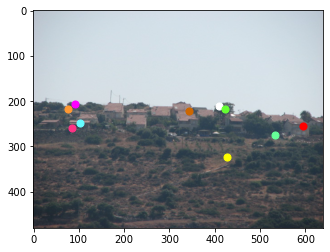

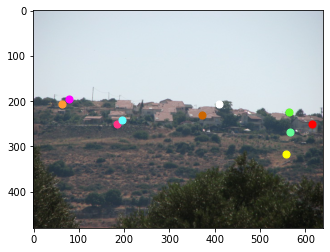

In [8]:
ann = Ann()
gen = General()
ratios = []

dataset1 = gen.read_dataset(fileName1)
dataset2 = gen.read_dataset(fileName2)

ann.fit(dataset1, 10, 10)  # we send K=10, L=10

for sample in dataset2:
    nearest_n, second_nearest = ann.ann_kneighbors(Vector(sample), 2)
    sample_dot, nearest_dot = gen.ratio(nearest_n, second_nearest, sample)

    if sample_dot is not None and nearest_dot is not None:
        ratio = nearest_n[1]/second_nearest[1]
        ratios.append([ratio, [sample_dot, nearest_dot]])

ratios.sort(key=lambda line: line[0])
    
counter=0
im1 = Image.open("Hananya1.JPG")
for i in ratios[:10]:
    img1 = ImageDraw.Draw(im1)
    plt.scatter(i[1][1][1], i[1][1][0], s=50, c=colors[counter])
    imgplot1 = plt.imshow(im1)

    counter += 1
plt.show()

counter=0
im2 = Image.open("Hananya2.JPG")
for i in ratios[:10]:
    img2 = ImageDraw.Draw(im2)
    plt.scatter(i[1][0][1], i[1][0][0], s=50, c=colors[counter])
    imgplot2 = plt.imshow(im2)

    counter += 1
plt.show()

# Section 4
In this section we will try to find the pair of K and L that will give us the most accurate result, we try out 10 different values of k with 10 different values of L.
For each pair we calculate the accuracy of the ANN. The calculation is explained in the general class under the "ann_epsilon_calculation" function.
We decided to work with the k and l values below after we checked several different option for values. we found that this values give us relatively varied results of error in ANN algorithm for different pairs of k&l.
At the end you can see a list that contains for each k&l pair its accuracy rate (epsilon).
We can see in the results that for some pairs in some runs the error rate (epsilon) is 0.0 (no error) and in other times it’s more than 0.0 (means there is some error). The reason is that the hastables's keys, that are used in our ANN algorithm, are generated based on random cuts, that change from run to run. So for example a specific sample can be with the same key as her (real) nearest neighbor, and if it happens for all of our samples than the accuracy will be 1.0 which means epsilon 0.0 (same results as KNN for each samples), but in other cases there might be few samples that have a different key from their real nearest neighbor, which will be later counted as a mistake (the algorithm will find a different closet neighbor or no neighbor at all if the sample’s key is empty).

In [9]:
knn = Knn()
ann = Ann()
gen = General()
k_values = [30, 28, 25, 23, 20, 15, 15, 12, 10, 5]
l = 1

dataset1 = gen.read_dataset(fileName1)
knn.fit(dataset1)

for k in k_values:
    for l in range(1, 10):
        ann.fit(dataset1, l, k)

        dataset2 = gen.read_dataset(fileName2)

        res = gen.ann_epsilon_calculation(dataset2, knn, ann, gen)

        param_list = [k, l]
        parameters_accuracy_res.append([param_list, res])

parameters_accuracy_res.sort(key=lambda line: line[1])

print("the 10 best parameter's values with the smallest accuracy error are:")
for i in parameters_accuracy_res[:10]:
    print(i)

the 10 best parameter's values with the smallest accuracy error are:
[[12, 6], 0.0]
[[12, 8], 0.0]
[[12, 9], 0.0]
[[10, 5], 0.0]
[[10, 8], 0.0]
[[10, 9], 0.0]
[[5, 3], 0.0]
[[5, 4], 0.0]
[[5, 5], 0.0]
[[5, 6], 0.0]


# Section 5
In this section, the user gives us an epsilon that will be the maximum error rate wanted, we use section d to find the parameters that will give us small enough error rate (we will use the results from section d for shortening running times). For each pair of parameters (l, k) which gives us this small error rate we measure their run time, and return the 5 fastest pairs as a list.

the five fastest ann are:
[[15, 6], 0.7895616000016616]
[[15, 9], 0.7985342999982095]
[[12, 5], 0.9537441999993916]
[[10, 6], 1.260891100003164]
[[12, 6], 1.274552800002084]


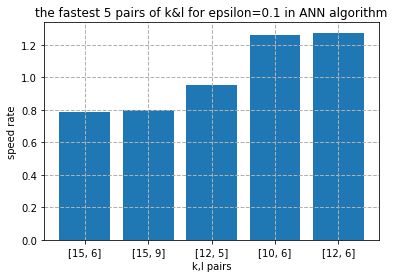

In [10]:
knn = Knn()
ann = Ann()
gen = General()
epsilon = 0.1
best_accuracy = []

for i in parameters_accuracy_res:
    if i[1] <= epsilon:
        best_accuracy.append([i[0], i[1]])

dataset1 = gen.read_dataset(fileName1)
dataset2 = gen.read_dataset(fileName2)

for i in best_accuracy:
    k = i[0][0]  # The k value of the best accuracy result 
    l = i[0][1]  # The l value of the best accuracy result

    ann.fit(dataset1, l, k)
    avg_ann_speed = gen.ann_speed_test(dataset2, knn, ann)
    param_list = [k, l]
    fastest_ann.append([param_list, avg_ann_speed])

fastest_ann.sort(key=lambda line: line[1])

print("the five fastest ann are:")
for i in fastest_ann[:5]:
    print(i)

k_l_array = []
speed_array = []
for i in fastest_ann[:5]:
    k_l_array.append(str(i[0]))
    speed_array.append(i[1])

x_values = np.arange(5)
plt.bar(x_values, speed_array)
plt.xlabel("k,l pairs")
plt.ylabel("speed rate")
plt.xticks(ticks=x_values, labels=k_l_array)
plt.grid(True, linewidth=1, linestyle="--")
plt.title("the fastest 5 pairs of k&l for epsilon=0.1 in ANN algorithm")
plt.show()

# Section 6
In this section we will run the ANN algorithm with the fastest pair of k&l we got from section 5 and display the different results of accuracy rate and speed from 10 iterations. The results are displayed in a dual bar chart, for each pair of k&l there is accuracy rate bar (the blue bar) and speed bar (the orange bar). The different results are due to the different hash-tables we have in each iteration. The difference is not because the k and l values (they are always the same), but because the different keys we get each iteration (we use random values for generating the keys, and this random values are changing in each iteration). The different keys we have each iteration allow the program to disperse the samples from the first dataset differently each time, so each time we get relativly different gatherings of neighbors. 
In contrary to what was explained so far, sometimes we can see that the accuracy is very similar in all of the runs, that’s because the k and l stay the same on all iterations. Because we use random values (as explaied before) it is possible that the data dispersing ,in the hash-tables, remains about the same so the probability that a sample will be considered as nearest neighbour is the same.

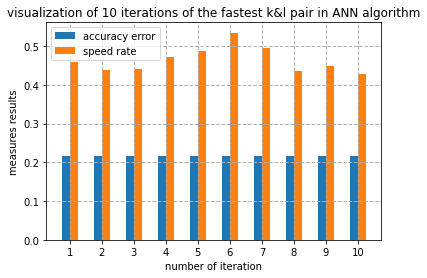

In [11]:
ann = Ann()
knn = Knn()
gen = General()
accuracy_total_res = []
speed_total_res = []

dataset1 = gen.read_dataset(fileName1)
dataset2 = gen.read_dataset(fileName2)

ann.fit(dataset1, fastest_ann[0][0][1], fastest_ann[0][0][0])
knn.fit(dataset1)

for i in range(10):
    accuracy_res = gen.ann_epsilon_calculation(dataset2, knn, ann, gen)
    speed_res = gen.ann_speed_test(dataset2, knn, ann)
    accuracy_total_res.append(accuracy_res)
    speed_total_res.append(speed_res)
    best_res_iteration_of_fastest_ann.append([speed_res, accuracy_res])
    
best_res_iteration_of_fastest_ann.sort(key=lambda line: line[0])
    
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.bar([a-0.25 for a in values], accuracy_total_res, width=0.25, label='accuracy error', align='edge')
plt.bar([a+0.25 for a in values], speed_total_res, width=-0.25, label='speed rate', align='edge')
plt.xlabel('number of iteration')
plt.ylabel('measures results')
plt.xticks(ticks=values, labels=values)
plt.legend(loc='upper left')
plt.grid(True, linewidth=1, linestyle="--")
plt.title('visualization of 10 iterations of the fastest k&l pair in ANN algorithm')
plt.show()

# Section 7
In this section we optimized the sklearn algorithm to get the best result by changing the algorithm type and the leaf size. We optimized this algorithm so that the comparison to our algorithm will be fair.
We decided to prioritize our results from section 6 based on the best speed time, we decided that because the accuracy results are usually very similar (explained in section 6). For the sklearn algorithm we also prioritized based on the speed because we saw that the accuracy is always 1 (the epsilon is always 0.0).

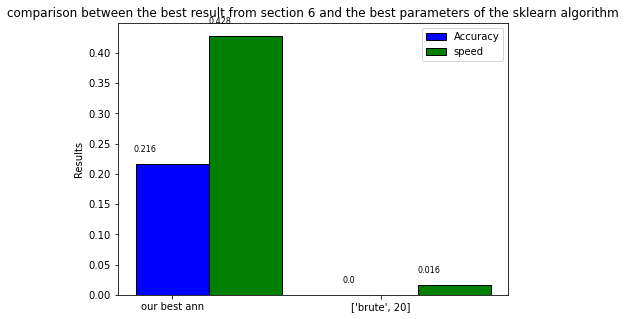

In [12]:
gen = General()
knn = Knn()

dataset1 = gen.read_dataset(fileName1)
dataset2 = gen.read_dataset(fileName2)

knn.fit(dataset1)

# running on all the algorithms except brute force (since it's like using KNN not ANN)
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_sizes = [1, 2, 15, 20, 30, 40]

data_for_nn = []
data_for_kneighbors = []
best_algorithm = []

for v in dataset1:
    data_for_nn.append(v[4:])

for v in dataset2:
    data_for_kneighbors.append(v[4:])

for a in algorithms:
    for l in leaf_sizes:
        nn = NearestNeighbors(n_neighbors=2, algorithm=a, leaf_size=l).fit(data_for_nn)  # creating the nn algorithm's object with different algorithm and leaf size
        start = timeit.default_timer()
        distances, indices = nn.kneighbors(data_for_kneighbors)
        stop = timeit.default_timer()
        speed = stop - start
        accuracy = ann_epsilon_calculation_for_sklearn(dataset2, knn, gen, distances, indices)
        parameters = [a, l]
        results = [speed, accuracy]
        best_algorithm.append([parameters, results])
        
best_algorithm.sort(key=lambda line: line[1][0])

x_lables = ['our best ann', best_algorithm[0][0]]
x_values = np.arange(2)
accuracy_y_values = [best_res_iteration_of_fastest_ann[0][1], best_algorithm[0][1][1]]
speed_y_values = [best_res_iteration_of_fastest_ann[0][0], best_algorithm[0][1][0]]
width = 0.35
plt.figure(figsize=(7,5))
plt.bar(x_values, accuracy_y_values, color = 'b', width = width, edgecolor = 'black', label='Accuracy')
plt.bar(x_values + width, speed_y_values, color = 'g', width = width, edgecolor = 'black',label='speed')
plt.ylabel('Results',size = 10)
plt.title('comparison between the best result from section 6 and the best parameters of the sklearn algorithm',size = 12) 
plt.xticks(ticks=x_values, labels=x_lables)

for i in range(len(x_values)):
    plt.text(x = i - width/2 - 0.01 , y = accuracy_y_values[i]+0.02, s = round(accuracy_y_values[i],3), size = 8)

for i in range(len(x_values)):
    plt.text(x = i + width/2 , y = speed_y_values[i]+0.02, s = round(speed_y_values[i],3), size = 8)
    
plt.legend()
  
plt.show()

# Section 9
In this section we return for each sample in dataset2 its neighbors that are close to it in a range of 1.5\*d(NN) according to our ANN.
d(NN) is the closest neighbor's distance based on the KNN.
we realized that for some samples the KNN algorithms doesn't return any neighbors, so in those cases we couldn't find the radius.
Each sample shown with its neighbors by our ANN algorithm, below we can see graph which compares between the result of our algorithm and the sklearn algorithm. The comparison is done on the 10 first samples from dataset 2 and by the number of neighbors each algorith return. We decided to show the graph only on the 10 first samples for convenience, because there a lot of samples in dataset2 and we want the graph to be readable.


sample's neighbors that are in range less then 1.5*d(NN)
the sample: [343.3, 298.24, 5.46, 2.046]
the neighbors from our method: [[356.55, 120.26, 5.22, 1.896]]


the sample: [328.45, 588.23, 5.05, 2.445]
the neighbors from our method: []


the sample: [236.58, 273.74, 4.62, 0.314]
the neighbors from our method: []


the sample: [230.24, 158.52, 5.14, 0.459]
the neighbors from our method: [[225.3, 435.66, 1.08, -0.956]]


the sample: [225.79, 589.14, 4.96, 0.962]
the neighbors from our method: [[201.95, 174.49, 1.69, 1.148]]


the sample: [224.38, 563.85, 3.99, 2.158]
the neighbors from our method: [[217.84, 421.63, 10.55, 1.782], [222.88, 308.68, 6.85, 1.846], [230.76, 600.29, 6.39, 2.273]]


the sample: [215.56, 23.4, 4.06, -1.496]
the neighbors from our method: []


the sample: [203.62, 85.56, 5.38, 1.45]
the neighbors from our method: []


the sample: [237.2, 272.26, 3.4, 0.185]
the neighbors from our method: []


the sample: [225.15, 224.12, 2.9, 1.52]
the neighbors from our metho

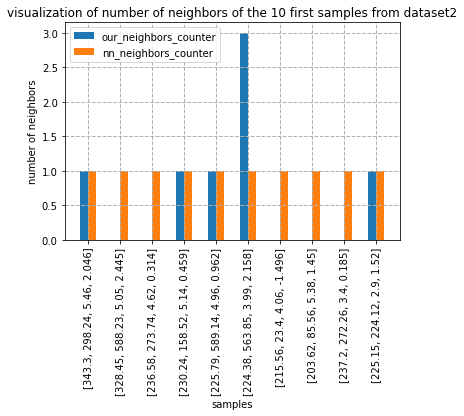

In [13]:
ann = Ann()
knn = Knn()
gen = General()
our_results = []
nn_results = []
data_for_nn = []
our_neighbors_counter = []
nn_neighbors_counter = []
x_lables = []

dataset1 = gen.read_dataset(fileName1)
dataset2 = gen.read_dataset(fileName2)

for v in dataset1:
    data_for_nn.append(v[4:])

knn.fit(dataset1)
ann.fit(dataset1, fastest_ann[0][0][1], fastest_ann[0][0][0])

for sample in dataset2:
    knn_nearest_n, knn_second_nearest = knn.knn_kneighbors(sample[4:], 2)
    knn_sample_dot, knn_nearest_dot = gen.ratio(knn_nearest_n, knn_second_nearest, sample)

    if knn_sample_dot is not None and knn_nearest_dot is not None:
        radius_value = 1.5*knn_nearest_n[1]
        
        nn = NearestNeighbors(radius=radius_value).fit(data_for_nn) # creating the nn algorithm's object with different radius
        rng = nn.radius_neighbors([sample[4:]], return_distance=False)  # getting the nearest neighbors in the wanted radius by the nn algorithm
        nn_results.append([Vector(sample).metadata, rng])
        
        neighbors = ann.neighbors_by_radios(radius_value, Vector(sample))  # getting the nearest neighbors in the wanted radius by our ANN algorithm
        our_results.append([Vector(sample).metadata, neighbors])
        
        x_lables.append(sample[:4])

print("sample's neighbors that are in range less then 1.5*d(NN)")
for i in our_results:
    print("the sample: " + str(i[0]))
    print("the neighbors from our method: " + str(i[1]))
    print("\n")
    
for r in range(10):
    our_neighbors_counter.append(len(our_results[r][1]))  # preparing data of y axis for the blue bar in the graph
    nn_neighbors_counter.append(len(nn_results[r][1]))  # preparing data of y axis for the orange bar in the graph

x_lables = x_lables[:10]
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.bar([a-0.25 for a in values], our_neighbors_counter, width=0.25, label='our_neighbors_counter', align='edge')
plt.bar([a+0.25 for a in values], nn_neighbors_counter, width=-0.25, label='nn_neighbors_counter', align='edge')
plt.xlabel('samples')
plt.ylabel('number of neighbors')
plt.xticks(ticks=values, labels=x_lables, rotation='vertical')
plt.legend(loc='upper left')
plt.grid(True, linewidth=1, linestyle="--")
plt.title('visualization of number of neighbors of the 10 first samples from dataset2')
plt.show()